In [1]:
import SimpleITK as sitk
import numpy as np
from PIL import Image
import napari
import skimage as sk
from pathlib import Path
import scipy as sc

In [ ]:
masks = sk.io.imread(r'Masks\205893_mask.png')

In [ ]:
masks.shape

In [ ]:
viewer = napari.view_image(masks)

In [ ]:
label_regions = sc.ndimage.binary_fill_holes(masks)
label_regions = sk.measure.label(label_regions)

In [ ]:
props = sk.measure.regionprops(label_regions)

In [ ]:
masked = label_regions * (label_regions==2)

In [ ]:
minc,minr,maxc,maxr = props[0].bbox
cropped_img = label_regions[minc:maxc,minr:maxr]

In [ ]:
sk.io.imsave(Path('Masks','205892_R2.png'),cropped_img,check_contrast=False)

In [2]:
#estimate spacing of map
map_img = Image.open('Maps/SD211_Left.png').convert('L')
map_img = np.array(map_img)


In [3]:
masked_R3 = map_img * (map_img==150)
label_R3 = sk.measure.label(masked_R3)

In [4]:
props_R3 = sk.measure.regionprops(label_R3)


In [5]:
minc,minr,maxc,maxr = props_R3[0].bbox
cropped_img = label_R3[minc:maxc,minr:maxr]
cropped_img.shape

(1997, 776)

In [6]:
source_r3 = sk.io.imread('Masks/205892_R3.png')
source_r3.shape

(3398, 1451)

In [7]:
source_spacing_y = source_r3.shape[0]
source_spacing_x = source_r3.shape[1]
map_spacing_y = source_spacing_y / cropped_img.shape[0]
map_spacing_x = source_spacing_x / cropped_img.shape[1]

In [19]:
MAP_SPACING = (map_spacing_y,map_spacing_x)
SOURCE_SPACING = (1.0,1.0)

In [9]:
def load_binary_with_spacing(path, spacing):
    """Load a mask image as binary SimpleITK image with physical spacing set."""
    img = Image.open(path).convert("L")
    arr = np.array(img)
    binary = (arr > 0).astype(np.float32)
    
    sitk_img = sitk.GetImageFromArray(binary)
    sitk_img.SetSpacing(spacing)  # critical — sets physical scale
    
    return sitk_img


def extract_region_with_spacing(label_mask_path, label_value, spacing, output_path=None):
    """Extract a single region from labeled map, with physical spacing set."""
    img = Image.open(label_mask_path).convert("L")
    arr = np.array(img)
    
    binary = (arr == label_value).astype(np.float32)

    sitk_img = sitk.GetImageFromArray(binary)
    sitk_img.SetSpacing(spacing)  # master map spacing
    
    if output_path:
        sitk.WriteImage(sitk_img, output_path)
    
    return sitk_img

In [ ]:
test_convert_img = Image.open('Maps/SD211_Left.png').convert('L')
test_convert_arr = np.array(test_convert_img)

In [ ]:
viewer = napari.view_image(test_convert_arr)

In [10]:
region_values = {
    1: {'label_value':29},
    2: {'label_value':76},
    3: {'label_value':150},
}

In [11]:
region_values = [29,76,150]

In [12]:
# Each source image can have its own spacing
source_images = {
    1: {"path": "Masks/205892_R1.png"},
    2: {"path": "Masks/205892_R2.png"},
    3: {"path": "Masks/205892_R3.png"},
}

# Extract fixed regions using master map spacing
region_masks = {
    i+1: extract_region_with_spacing(
        "Maps/SD211_Left.png",
        label_value=region_values[i],
        spacing=MAP_SPACING
    )
    for i in range(len(region_values))
}

In [13]:
def extract_matrix(transform):
    """Convert SimpleITK AffineTransform to 3x3 homogeneous matrix."""
    matrix_2x2 = np.array(transform.GetMatrix()).reshape(2, 2)
    translation = np.array(transform.GetTranslation())
    center = np.array(transform.GetFixedParameters()[:2])
    
    translation_full = -matrix_2x2 @ center + center + translation
    
    M = np.eye(3)
    M[:2, :2] = matrix_2x2
    M[:2, 2] = translation_full
    return M

In [14]:
def extract_matrix(transform):
    """Convert SimpleITK AffineTransform (or CompositeTransform wrapping one) 
    to a 3x3 homogeneous matrix in physical space."""
    
    # Unwrap CompositeTransform if necessary
    if transform.GetName() == "CompositeTransform":
        # The affine component is the last transform in the composite
        n = transform.GetNumberOfTransforms()
        print(f"  CompositeTransform detected with {n} component(s) — extracting inner AffineTransform")
        affine = transform.GetNthTransform(n - 1)
    else:
        affine = transform
    
    # Verify we now have what we expect
    print(f"  Transform type: {affine.GetName()}")
    
    matrix_2x2 = np.array(affine.GetMatrix()).reshape(2, 2)
    translation = np.array(affine.GetTranslation())
    center      = np.array(affine.GetFixedParameters()[:2])
    
    # Fold the fixed center into the translation
    # Full transform: x' = M*(x - center) + center + translation
    translation_full = -matrix_2x2 @ center + center + translation
    
    M = np.eye(3)
    M[:2, :2] = matrix_2x2
    M[:2, 2]  = translation_full
    
    return M

In [ ]:
for label_id, source_info in source_images.items():
    print(source_info['path'])

In [ ]:
def to_distance_map(sitk_binary_img):
    """Convert binary mask to distance map — much richer gradient signal."""
    # Signed distance: positive inside, negative outside
    dist = sitk.SignedMaurerDistanceMap(
        sitk.Cast(sitk_binary_img, sitk.sitkUInt8),
        insideIsPositive=True,
        squaredDistance=False,
        useImageSpacing=True
    )
    return dist

In [21]:
transforms = {}
matrices   = {}

for label_id, source_info in source_images.items():
    
    fixed  = region_masks[label_id]
    moving = load_binary_with_spacing(source_info["path"], SOURCE_SPACING)
    
    # Confirm physical extents before registering — useful sanity check
    fixed_extent  = np.array(fixed.GetSize())  * np.array(fixed.GetSpacing())
    moving_extent = np.array(moving.GetSize()) * np.array(moving.GetSpacing())
    print(f"\nLabel {label_id}")
    print(f"  Fixed  physical extent: {fixed_extent}  px size: {fixed.GetSize()}")
    print(f"  Moving physical extent: {moving_extent}  px size: {moving.GetSize()}")
    
    registration = sitk.ImageRegistrationMethod()
    registration.SetMetricAsMeanSquares()
    
    initial_transform = sitk.CenteredTransformInitializer(
        fixed, moving,
        sitk.AffineTransform(2),
        sitk.CenteredTransformInitializerFilter.MOMENTS
    )
    registration.SetInitialTransform(initial_transform, inPlace=False)
    
    registration.SetOptimizerAsLBFGS2(
    solutionAccuracy=1e-5,
    numberOfIterations=500,
    deltaConvergenceTolerance=0.01
    )
    
    registration.SetOptimizerScalesFromPhysicalShift()
    registration.SetShrinkFactorsPerLevel(shrinkFactors=[8, 4, 2, 1])
    registration.SetSmoothingSigmasPerLevel(smoothingSigmas=[4, 2, 1, 0])
    registration.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    registration.SetInterpolator(sitk.sitkLinear)
    
    print(f"  Registering...")
    final_transform = registration.Execute(fixed, moving)
    print(f"  Metric: {registration.GetMetricValue():.6f}")
    
    transforms[label_id] = final_transform
    matrices[label_id]   = extract_matrix(final_transform)  # same function as before
    
    np.savetxt(f"affine_matrix_label_{label_id}.csv", matrices[label_id],
               delimiter=",", header="col1,col2,col3", comments="")


Label 1
  Fixed  physical extent: [5899.28192288 7827.14071107]  px size: (3467, 4600)
  Moving physical extent: [5067. 3353.]  px size: (5067, 3353)
  Registering...
  Metric: 0.323163
  CompositeTransform detected with 1 component(s) — extracting inner AffineTransform
  Transform type: AffineTransform

Label 2
  Fixed  physical extent: [5899.28192288 7827.14071107]  px size: (3467, 4600)
  Moving physical extent: [5213. 3636.]  px size: (5213, 3636)
  Registering...
  Metric: 0.260787
  CompositeTransform detected with 1 component(s) — extracting inner AffineTransform
  Transform type: AffineTransform

Label 3
  Fixed  physical extent: [5899.28192288 7827.14071107]  px size: (3467, 4600)
  Moving physical extent: [1451. 3398.]  px size: (1451, 3398)
  Registering...
  Metric: 0.250189
  CompositeTransform detected with 1 component(s) — extracting inner AffineTransform
  Transform type: AffineTransform


In [22]:
import copy

def multi_start_registration(fixed, moving, n_rotations=8):
    """
    Try N evenly-spaced initial rotations, run full registration from each,
    return the transform with the best final metric.
    """
    best_metric    = np.inf
    best_transform = None
    
    angles = np.linspace(0, 2 * np.pi, n_rotations, endpoint=False)
    
    for i, angle in enumerate(angles):
        # Build rotated initial transform
        init = sitk.CenteredTransformInitializer(
            fixed, moving, sitk.AffineTransform(2),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        # Apply rotation offset
        affine = sitk.AffineTransform(2)
        affine.SetCenter(init.GetFixedParameters()[:2])
        rot = np.array([[np.cos(angle), -np.sin(angle)],
                        [np.sin(angle),  np.cos(angle)]])
        affine.SetMatrix(rot.flatten().tolist())
        affine.SetTranslation(init.GetTranslation())
        
        reg = sitk.ImageRegistrationMethod()
        reg.SetMetricAsMeanSquares()
        reg.SetInitialTransform(affine, inPlace=False)
        reg.SetOptimizerAsGradientDescent(
            learningRate=1.0, numberOfIterations=300,
            convergenceMinimumValue=1e-6, convergenceWindowSize=10
        )
        reg.SetOptimizerScalesFromPhysicalShift()
        reg.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
        reg.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
        reg.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
        reg.SetInterpolator(sitk.sitkLinear)
        
        try:
            result = reg.Execute(fixed, moving)
            metric = reg.GetMetricValue()
            print(f"  Start {i+1}/{n_rotations} (angle={np.degrees(angle):.0f}°) metric: {metric:.6f}")
            
            if metric < best_metric:
                best_metric    = metric
                best_transform = result
        except Exception as e:
            print(f"  Start {i+1} failed: {e}")
    
    print(f"  Best metric: {best_metric:.6f}")
    return best_transform

In [23]:
transforms = {}
matrices   = {}

for label_id, source_info in source_images.items():
    
    fixed  = region_masks[label_id]
    moving = load_binary_with_spacing(source_info["path"], SOURCE_SPACING)
    best_transform = multi_start_registration(fixed,moving)
    transforms[label_id] = best_transform
    matrices[label_id]   = extract_matrix(best_transform)  # same function as before
    
    np.savetxt(f"affine_matrix_label_{label_id}.csv", matrices[label_id],
               delimiter=",", header="col1,col2,col3", comments="")

  Start 1/8 (angle=0°) metric: 0.197792
  Start 2/8 (angle=45°) metric: 0.169258
  Start 3/8 (angle=90°) metric: 0.234881
  Start 4/8 (angle=135°) metric: 0.232632
  Start 5/8 (angle=180°) metric: 0.249671
  Start 6/8 (angle=225°) metric: 0.209202
  Start 7/8 (angle=270°) metric: 0.181291
  Start 8/8 (angle=315°) metric: 0.190846
  Best metric: 0.169258
  CompositeTransform detected with 1 component(s) — extracting inner AffineTransform
  Transform type: AffineTransform
  Start 1/8 (angle=0°) metric: 0.173931
  Start 2/8 (angle=45°) metric: 0.111802
  Start 3/8 (angle=90°) metric: 0.147030
  Start 4/8 (angle=135°) metric: 0.142373
  Start 5/8 (angle=180°) metric: 0.054560
  Start 6/8 (angle=225°) metric: 0.158221
  Start 7/8 (angle=270°) metric: 0.108602
  Start 8/8 (angle=315°) metric: 0.141437
  Best metric: 0.054560
  CompositeTransform detected with 1 component(s) — extracting inner AffineTransform
  Transform type: AffineTransform
  Start 1/8 (angle=0°) metric: 0.767682
  Start 2/

In [17]:
def load_as_binary_sitk(path):
    """Load any mask/annotation image as a binary SimpleITK image."""
    img = Image.open(path).convert("L")
    arr = np.array(img)
    binary = (arr > 0).astype(np.float32)
    return sitk.GetImageFromArray(binary)

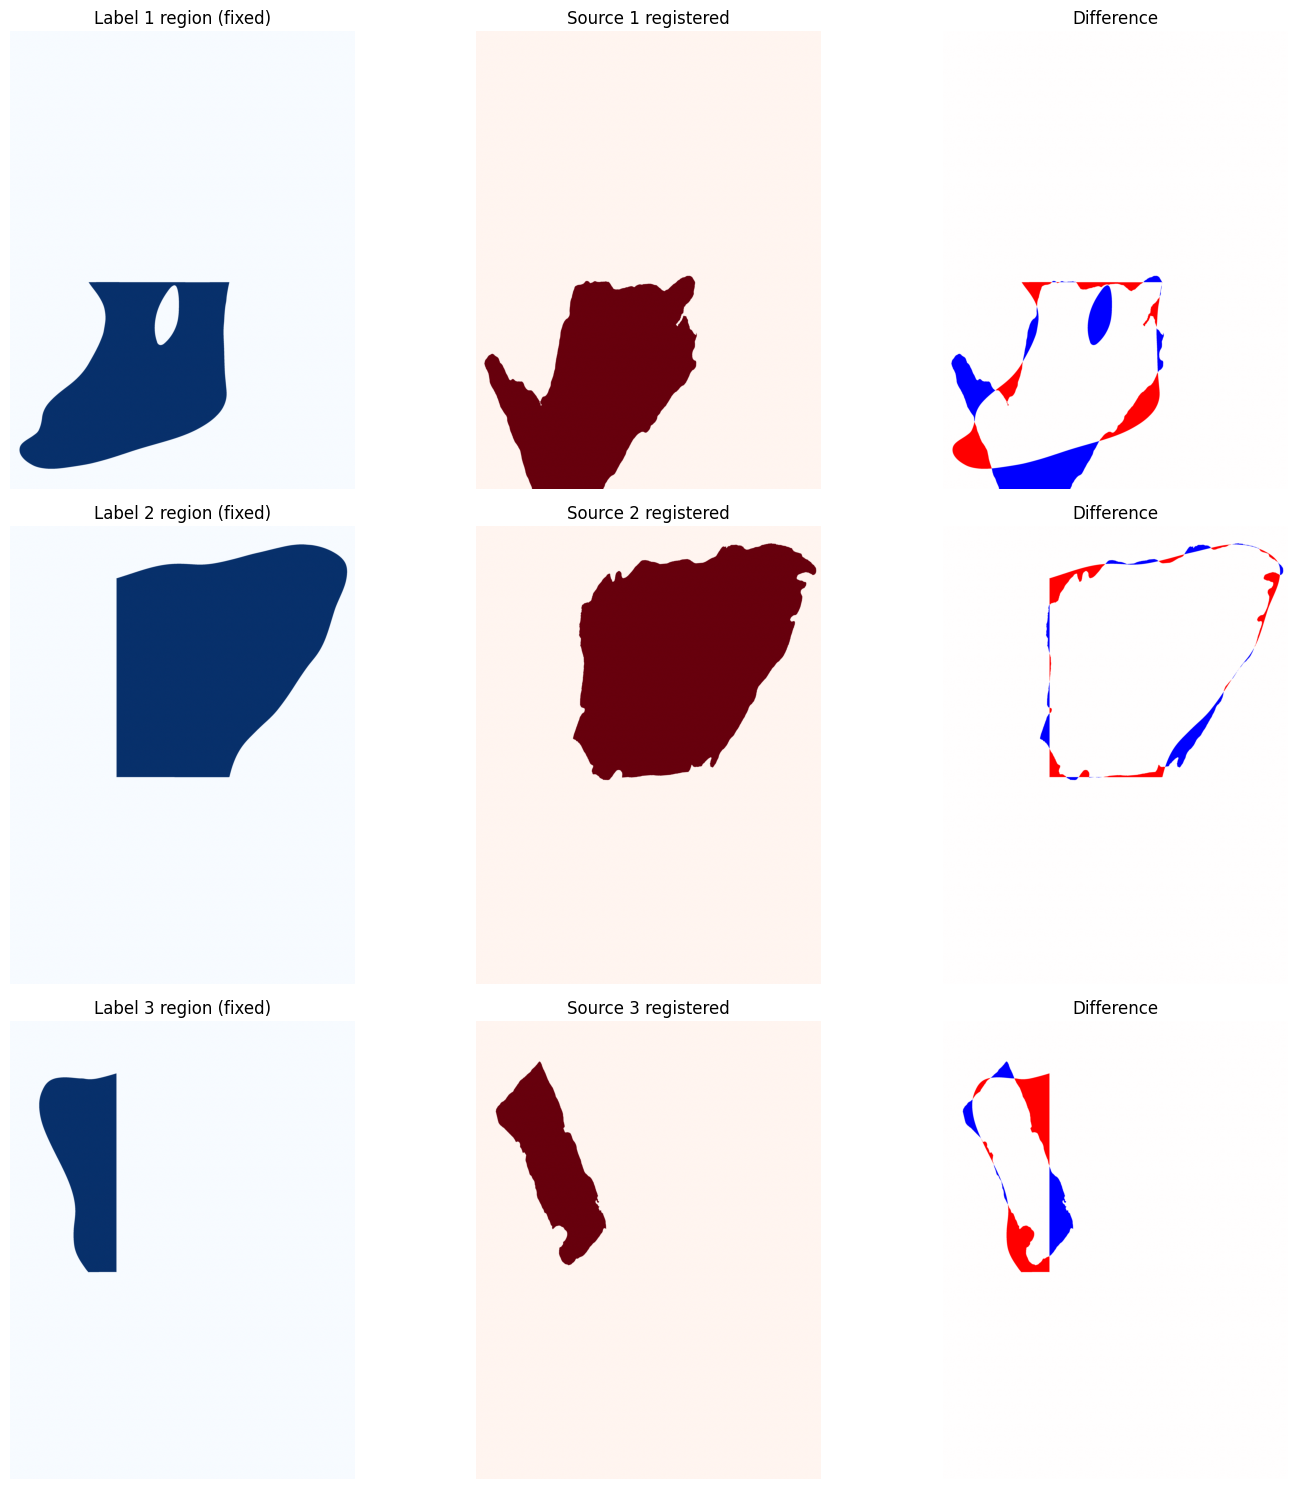

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, label_id in enumerate(source_images.keys()):
    fixed = region_masks[label_id]
    moving = load_as_binary_sitk(source_images[label_id]['path'])
    
    resampled = sitk.Resample(
        moving, fixed, transforms[label_id],
        sitk.sitkNearestNeighbor, 0.0, moving.GetPixelID()
    )
    
    fixed_arr   = sitk.GetArrayFromImage(fixed)
    moved_arr   = sitk.GetArrayFromImage(resampled)
    
    axes[i, 0].imshow(fixed_arr,             cmap="Blues");  axes[i, 0].set_title(f"Label {label_id} region (fixed)")
    axes[i, 1].imshow(moved_arr,             cmap="Reds");   axes[i, 1].set_title(f"Source {label_id} registered")
    axes[i, 2].imshow(fixed_arr - moved_arr, cmap="bwr")
    axes[i, 2].set_title("Difference")
    for ax in axes[i]: ax.axis("off")

plt.tight_layout()
plt.savefig("registration_verification.png", dpi=150)
plt.show()

In [ ]:
# Save a spacing reference file so R knows the coordinate system
import json

spacing_info = {
    "master_map_spacing_um_per_px": MASTER_MAP_SPACING,
    "source_spacings_um_per_px": {
        str(k): v["spacing"] for k, v in source_images.items()
    },
    "transform_space": "physical_units",
    "notes": "Multiply pixel coords by spacing before applying matrix"
}

with open("spacing_info.json", "w") as f:
    json.dump(spacing_info, f, indent=2)